# Part 4 -- Han

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4.1 Libraries

In [3]:
import os
import sys
sys.path.append("/content/drive/MyDrive/CS5242/")
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.metrics import f1_score, accuracy_score
from IPython import display
import time
import sklearn.metrics
import json
import collections
import numpy as np
import pandas as pd
from transformers.optimization import get_cosine_schedule_with_warmup
import math
import copy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class Args(object):
    def __init__(self):
        super().__init__()
        self.optimizer = 'adamw'
        self.batch_size = 16
        self.num_epochs = 10
        self.lr = 1e-3
        self.weight_decay = 1e-4
        self.lr_period = 4
        self.lr_decay = 0.8
        self.dropout = 0.1
        self.embedding_dim = 300
        self.hidden_dim = 300
        self.num_class = 3
        self.num_aspect = 6
        self.max_seq_len = 500
        self.num_warmup_steps = 200
        self.pt_path = "/content/drive/MyDrive/CS5242/ckpt"
        self.img_path = "/content/drive/MyDrive/CS5242/images"
        self.learning_rates = []
        self.monitor = 'loss'

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

    def save(self, output_dir, fname):
        plt.savefig(os.path.join(output_dir, fname), dpi=600)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: [batch_size, num_classes]
        targets: [batch_size] with class indices (0, 1, 2)
        """
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def accuracy(y_pred, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = torch.argmax(y_pred, axis=1)
    cmp = (y_pred.type(y.dtype)) == y
    return float(torch.sum(cmp.type(y.dtype)))

def download_model(model_name,cache_dir):
  if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
  tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
  model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir)
  total, trainable = count_parameters(model)
  print(f"Total Parameters: {total:,}, Trainable: {trainable:,}")
  print(model)

def evaluate_loss_and_acc_gpu(net, data_iter, loss=None, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    if loss:
        metric = Accumulator(3)
    else:
        metric = Accumulator(2)

    with torch.no_grad():
        for batch in data_iter:
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)
            y = batch['label']
            y_pred = net(**batch)
            if loss:
                metric.add(loss(y_pred, y).sum(), accuracy(y_pred, y), torch.numel(y))
            else:
                metric.add(accuracy(y_pred, y), torch.numel(y))
    return (metric[0] / metric[2], metric[1] / metric[2]) if loss else metric[0] / metric[1]

def train_batch(net, batch, loss, trainer, devices):
    """Train for a minibatch """
    if isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = batch[k].to(devices[0])
    else:
        batch = batch.to(devices[0])
    y = batch['label']
    net.train()
    trainer.zero_grad()
    pred = net(**batch)
    l = loss(pred, y)
    l.mean().backward()
    trainer.step()
    train_loss_sum = l.sum().item()
    train_acc_sum = accuracy(pred, y)
    args.learning_rates.append(trainer.param_groups[0]["lr"])
    return train_loss_sum, train_acc_sum

def train_transformer(net,
                      train_iter,
                      valid_iter,
                      num_epochs,
                      optimizer,
                      lr,
                      wd,
                      num_warmup_steps,
                      devices,
                      task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(tqdm(train_iter)):
            timer.start()
            labels = batch['label']
            output = train_batch(net, batch, loss, trainer, devices)
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

def test(net, data_iter, output_dir=None, device=None):
    net.eval()
    full_logits=[]
    full_label_ids=[]
    for i, batch in tqdm(enumerate(data_iter)):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())

    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on final epoch -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

def test_on_checkpoint(net, file_path, data_iter, output_dir=None, device=None):
    state_dict = torch.load(file_path, map_location=device)
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()
    full_logits=[]
    full_label_ids=[]
    full_aspect_ids = []
    for i, batch in enumerate(data_iter):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())


    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on {file_path} -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

class BGEProcessor(object):
    def __init__(self, data_dir, data_name):
        self.data_dir = data_dir
        self.data_name = data_name

    def get_examples(self):
        """Read data from json file.
        Args:
            data_dir (string):
                Path.
            mode (string):
                Indicate train/dev/test.
        Returns:
            examples for different modes.
        """
        return self._create_examples(self._read_json(os.path.join(self.data_dir, self.data_name)))

    def get_labels(self):
        """Return labels for specific dataset"""
        return ["negative", "neutral", "positive"]

    def _create_examples(self, datas):
        """Creates examples for the training and dev sets."""
        examples = []
        for idx,data in enumerate(datas):
            data['label'] = int(data["label"])
            examples.append(data)
        return examples

    def _read_json(self, input_file):
        """Reads a json file for tasks in sentiment analysis."""
        datas = []
        with open(input_file, 'r', encoding='utf-8') as f:
          for line in f:
              obj = json.loads(line)
              datas.append(obj)
        return datas


## 4.1 BGE Model

<div style="display: flex; justify-content: center;">
  <img src="img/RetroMAE.png" alt="RetroMAE" width="500"/>
</div>

#### Removal of the NSP (Next Sentence Prediction) Task
BERT originally employed the **NSP** task to model relationships between sentences. However, subsequent research has shown that **NSP** provides limited benefits for downstream performance. BGE removes the **NSP** task entirely to avoid introducing unnecessary noise, allowing the model to focus more on fine-grained semantic representation learning.

#### Introduction of the MLLM (Masked Language Model for Matching) Pretraining Objective
BGE adopts a specially designed **MLLM** objective tailored for retrieval tasks. It combines masked language modeling with semantic matching, not only predicting masked tokens but also enhancing the modeling of relevance between paired texts.

#### Integration of RetroMAE as a Decoder Module
During pretraining, BGE incorporates **RetroMAE(Retrieval-oriented Masked AutoEncoder)**  as its decoder component to strengthen the model’s representation learning capability. By reconstructing the hidden representations of the original text, RetroMAE guides the encoder to learn more retrieval-friendly vector distributions, leading to significant improvements in retrieval-related tasks.

#### Incorporating Contrastive Learning

The BGE model introduces **contrastive learning** during pretraining to optimize sentence embeddings for semantic retrieval tasks.Unlike traditional language models like BERT, which are trained with **Masked Language Modeling** and **Next Sentence Prediction**, BGE focuses on learning embeddings where semantically similar sentences are close together in the vector space, and dissimilar ones are far apart.

## 4.2 Single Tower Relevance Modeling with BGE

<div style="display: flex; justify-content: center;">
  <img src="img/single_tower_bge.jpg" alt="single_tower_bge" width="500"/>
</div>

Single Tower Relevance Modeling with BGE refers to a design where both the query and document are concatenated and jointly fed into a single encoder, typically a transformer-based language model. The single-tower approach enables deeper interaction between the two inputs. This allows the model to better capture fine-grained semantic relationships and contextual dependencies. 
In BGE, the input format usually follows **[CLS] Query [SEP] Document [SEP]**, and the relevance score is computed from the **[CLS]** token embedding using a simple classifier. Although single-tower models are computationally heavier during inference, they often yield higher performance in tasks requiring precise matching, such as question answering and passage ranking.


## 5.8.1 Single Tower Relevance Modeling with BGE

<div style="display: flex; justify-content: center;">
  <img src="img/single_tower_bge.jpg" alt="single_tower_bge" width="500"/>
</div>

Single Tower Relevance Modeling with BGE refers to a design where both the query and document are concatenated and jointly fed into a single encoder, typically a transformer-based language model. The single-tower approach enables deeper interaction between the two inputs. This allows the model to better capture fine-grained semantic relationships and contextual dependencies. 
In BGE, the input format usually follows **[CLS] Query [SEP] Document [SEP]**, and the relevance score is computed from the **[CLS]** token embedding using a simple classifier. Although single-tower models are computationally heavier during inference, they often yield higher performance in tasks requiring precise matching, such as question answering and passage ranking.


In [4]:
class SingleTowerBGEDataset(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, model_name, cache_dir, samples):
        self.model_name = model_name
        self.samples = samples
        print(len(self.samples))
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.convert_data_to_features()

    def convert_data_to_features(self):
        """convert examples to features"""
        label_map = {0: 0, 1: 1, 2: 2}

        output = []
        for (i, sample) in tqdm(enumerate(self.samples)):
            feature = {}
            query = sample['query']
            document = sample['title']
            inputs = self.tokenizer(query,
                                    document,
                                    return_tensors="pt",
                                    padding=True,
                                    truncation=True)

            input_ids = inputs["input_ids"][0]
            token_type_ids  = inputs["token_type_ids"][0]
            attention_mask = inputs["attention_mask"][0]
            label_id = label_map[sample['label']]
            feature = {
                "input_ids": input_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "label_id": label_id
            }
            output += [feature]
        self.data = output

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        input_ids = [item['input_ids'] for item in batch]
        attention_mask = [item['attention_mask'] for item in batch]
        token_type_ids = [item['token_type_ids'] for item in batch]
        label_ids = torch.tensor([item['label_id'] for item in batch])

        padded = tokenizer.pad(
            {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "token_type_ids": token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "input_ids": padded["input_ids"],
            "attention_mask": padded["attention_mask"],
            "token_type_ids": padded["token_type_ids"],
            "label": label_ids
        }
    return collate_fn

class DualTowerBGEDataset(Dataset):
    """Build dataset for dual tower model and convert examples to features separately"""
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.samples = samples
        self.data = self.convert_data_to_features(samples)

    def convert_data_to_features(self, samples):
        label_map = {0: 0, 1: 1, 2: 2}
        features = []

        for sample in tqdm(samples, desc="Converting data"):
            query = sample['query']
            document = sample['title']
            label = label_map[sample['label']]

            query_inputs = self.tokenizer(query,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)
            doc_inputs = self.tokenizer(  document,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)

            feature = {
                "query_input_ids": query_inputs["input_ids"].squeeze(0),
                "query_attention_mask": query_inputs["attention_mask"].squeeze(0),
                "query_token_type_ids": query_inputs["token_type_ids"].squeeze(0),

                "doc_input_ids": doc_inputs["input_ids"].squeeze(0),
                "doc_attention_mask": doc_inputs["attention_mask"].squeeze(0),
                "doc_token_type_ids": doc_inputs["token_type_ids"].squeeze(0),

                "label": label
            }
            features.append(feature)
        return features

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_dual_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        query_input_ids = [item['query_input_ids'] for item in batch]
        query_attention_mask = [item['query_attention_mask'] for item in batch]
        query_token_type_ids = [item['query_token_type_ids'] for item in batch]

        doc_input_ids = [item['doc_input_ids'] for item in batch]
        doc_attention_mask = [item['doc_attention_mask'] for item in batch]
        doc_token_type_ids = [item['doc_token_type_ids'] for item in batch]

        label_ids = torch.tensor([item['label'] for item in batch])

        # Padding query
        query_batch = tokenizer.pad(
            {
                "input_ids": query_input_ids,
                "attention_mask": query_attention_mask,
                "token_type_ids": query_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        doc_batch = tokenizer.pad(
            {
                "input_ids": doc_input_ids,
                "attention_mask": doc_attention_mask,
                "token_type_ids": doc_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "query_input_ids": query_batch["input_ids"],
            "query_attention_mask": query_batch["attention_mask"],
            "query_token_type_ids": query_batch["token_type_ids"],
            "doc_input_ids": doc_batch["input_ids"],
            "doc_attention_mask": doc_batch["attention_mask"],
            "doc_token_type_ids": doc_batch["token_type_ids"],
            "label": label_ids
        }

    return collate_fn

In [5]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-base-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
task_name = "SingleTowerBGE"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
download_model(model_name,cache_dir)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total Parameters: 102,267,648, Trainable: 102,267,648
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
class SingleTowerBGE(nn.Module):
    """ Transformer encoder"""
    def __init__(self, model_name,cache_dir,output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.bge = AutoModel.from_pretrained(self.model_name,cache_dir=self.cache_dir)
        self.d_model = self.bge.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, input_ids, attention_mask, token_type_ids, **kwarg):
        outputs = self.bge(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
        ).last_hidden_state
        logits = self.clf(outputs[:,0,:])
        return logits

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

In [ ]:
train_data = SingleTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = SingleTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = SingleTowerBGEDataset(model_name, cache_dir,test_examples)

16000


16000it [00:05, 2688.04it/s]


2000


2000it [00:01, 1955.51it/s]


2000


2000it [00:00, 2373.35it/s]


In [ ]:
train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                       shuffle=False)

In [ ]:
net = SingleTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])

train loss 0.224, train acc 0.923, valid loss 1.012, valid acc 0.647
77.4 examples/sec on [device(type='cuda')]


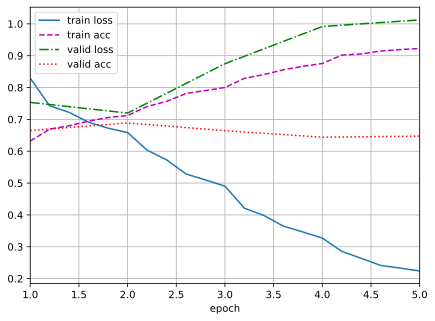

In [ ]:
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
32it [00:09,  3.47it/s]


test on final epoch -- acc: 65.80, f1-macro: 56.21
test on /content/drive/MyDrive/CS5242/ckpt/SingleTowerBGE-epoch1-val_acc0.69.pt -- acc: 70.25, f1-macro: 50.29


## 5.8.2 Dual Tower Relevance Modeling with BGE

<div style="display: flex; justify-content: center;">
  <img src="img/dual_tower_bge.jpg" alt="dual_tower_bge" width="500"/>
</div>

Dual Tower Relevance Modeling with BGE refers to a design where the query and document are processed separately through two independent encoders, typically based on transformer architectures. Each encoder generates a dense embedding for its respective input (query or document). The relevance score is then computed based on the similarity (e.g., dot product or cosine similarity) between the two embeddings.

Compared to single-tower models, the dual-tower approach enables much faster inference because query and document embeddings can be pre-computed and stored for efficient retrieval. Although dual-tower models might sacrifice some fine-grained interaction between the query and document, they are highly scalable and particularly effective for large-scale retrieval tasks.

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-small-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "DualTowerBGE"
download_model(model_name,cache_dir)

Total Parameters: 23,953,920, Trainable: 23,953,920
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

In [ ]:
train_data = DualTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = DualTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = DualTowerBGEDataset(model_name, cache_dir,test_examples)

Converting data: 100%|██████████| 2000/2000 [00:00<00:00, 2631.17it/s]


In [ ]:
class DualTowerBGE(nn.Module):
    """ Dual Tower Transformer Encoder """
    def __init__(self, model_name, cache_dir, output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.query_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.doc_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.d_model = self.query_encoder.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model * 2, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, query_input_ids,
                      query_attention_mask,
                      query_token_type_ids,
                      doc_input_ids,
                      doc_attention_mask,
                      doc_token_type_ids,
                      **kwargs):
        '''
        query_inputs: dict, doc_inputs: dict
        Including input_ids, attention_mask, token_type_ids
        '''
        query_inputs = {"input_ids":query_input_ids,
                        "attention_mask":query_attention_mask,
                        "token_type_ids":query_token_type_ids}
        doc_inputs   = {"input_ids":doc_input_ids,
                        "attention_mask":doc_attention_mask,
                        "token_type_ids":doc_token_type_ids}
        query_output = self.query_encoder(**query_inputs).last_hidden_state[:, 0, :]  # [CLS]
        doc_output = self.doc_encoder(**doc_inputs).last_hidden_state[:, 0, :]        # [CLS]
        concat = torch.cat([query_output, doc_output], dim=-1)  # [batch, 2*d_model]
        logits = self.clf(concat)
        return logits


In [ ]:
train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

In [ ]:
net = DualTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])

train loss 0.510, train acc 0.793, valid loss 0.876, valid acc 0.646
381.3 examples/sec on [device(type='cuda')]


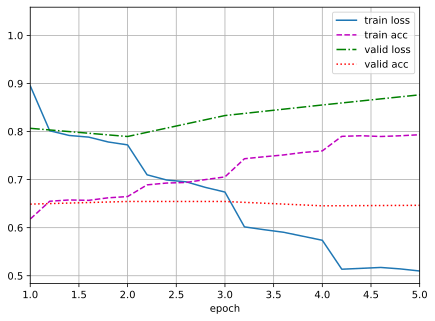

In [ ]:
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

32it [00:01, 16.55it/s]


test on final epoch -- acc: 66.70, f1-macro: 44.63
test on /content/drive/MyDrive/CS5242/ckpt/DualTowerBGE-epoch1-val_acc0.65.pt -- acc: 66.70, f1-macro: 44.63


### 5.8.3 Knowledge Distillation

A powerful single-tower model is used as the **teacher** to train a dual-tower **student** through knowledge distillation.

The **single-tower teacher** computes high-quality similarity scores by jointly encoding the query and document.
The **dual-tower student** encodes query and document separately and tries to match the teacher's scores.
The student learns to approximate the teacher’s behavior while maintaining efficiency.

Dual-tower is much faster at inference (suitable for large-scale retrieval).Single-tower provides more accurate supervision thanks to full input interaction.Knowledge Distillation Combine the performance of a strong teacher with the speed of a lightweight student.

**KL divergence loss:**
$$
\mathcal{L}_{\text{KD}} = T^2 \times \sum_{i} p^t_i \log\left( \frac{p^t_i}{p^s_i} \right)
$$

**Total loss combining hard and soft targets:**
$$
\mathcal{L} = \alpha \times \mathcal{L}_{\text{CE}}(y, p^s) + (1 - \alpha) \times \mathcal{L}_{\text{KD}}
$$

**Where:**
- Loss between teacher and student outputs: $ \mathcal{L}_{\text{KD}} $
- Cross-entropy loss between true labels and student predictions: $ \mathcal{L}_{\text{CE}} $
- Teacher soft targets after temperature scaling:  $ p^t $
- Student soft targets after temperature scaling:  $ p^s $
- Temperature parameter: $ T $
- Balance hyperparameter: $ \alpha \in [0, 1] $
- Ground-truth labels: $ y $

### 5.8.4 Conclusion

In this study, we independently trained a **Single-Tower Model** and a **Two-Tower Model** using **direct supervised learning**. Subsequently, the trained single-tower model was employed as the **teacher** to conduct **knowledge distillation** for the two-tower **student model**. The key findings are summarized as follows:

Results of Direct Supervised Training

- The single-tower model demonstrated superior performance, characterized by rapid convergence and high final accuracy.
- In contrast, the two-tower model exhibited relatively inferior performance under direct supervision, likely due to its increased representational capacity, which complicates the direct fitting of hard labels.

Results of Knowledge Distillation

- After undergoing knowledge distillation from the single-tower teacher, the two-tower student model exhibited a substantial performance improvement.
- This outcome indicates that the student model benefited from the richer, smoother soft target distributions provided by the teacher, which effectively mitigated overfitting and eased the optimization difficulties inherent in learning solely from hard labels.

Analysis

- The single-tower model, through direct supervised training, captures compact and well-structured feature representations, thereby serving as an effective teacher capable of offering more precise and informative guidance.
- Owing to its larger parameter space and higher flexibility, the two-tower model is able to better refine its representation space by leveraging the "dark knowledge" conveyed by the teacher — such as inter-class similarity information — ultimately leading to enhanced downstream task performance.


### 5.9.1  Relevance Modeling with Large Language Model

**Data Preparation Phase**

- **Data Conversion**: Convert the raw query, document, and label data into the input format required by the large model (ChatML conversation format). This step ensures that the data is structured appropriately for model consumption.
- **Tokenization**: Once the data is converted, apply tokenization to split the content into smaller units (tokens). This will generate the following outputs:
  - `input_ids`: Numerical representations of the tokens.
  - `attention_mask`: A mask to indicate which tokens should be attended to by the model.
  - `labels`: The ground truth labels that will be used for training the model, typically indicating the relevance score (0/1/2).

**Model Training Phase**

- **Model Selection**: Use a standard large language model (LLM) which is Qwen-0.5B, that is capable of processing the input query and document pairs.
- **Input Structure**: The model receives a prompt consisting of the concatenated query and document. The model's goal is to predict the relevance score (0/1/2) for each query-document pair.
- **Loss Function**: The training loss is computed using the standard language model loss, which is typically the cross-entropy loss applied to the token predictions. This loss guides the model to improve its predictions by adjusting the weights based on the error in token prediction.

**Model Testing Phase**

- **Input Structure**: During testing, the model is given the query and document as input but does not receive the correct answer label. The model must generate its own relevance score (0/1/2) based on its learned understanding.
- **Generation and Evaluation**: The model's output is compared against the true label to assess its performance. The accuracy of the generated relevance score is measured to evaluate how well the model has learned to predict relevance.

**Example**

  System:

  You are a search engine. You need to judge the relevance between a given user query and a document snippet.
  Score according to the following rules, range 0–2:

  0 – Not relevant;

  1 – Somewhat relevant;

  2 – Relevant.

  User Query:

  “From the date of filing for divorce, if either party does not agree to the divorce, they may apply to…”

  Document Snippet:

  “According to the Civil Code of the People’s Republic of China, from the date the marriage registration authority receives a divorce registration application, if either party is unwilling to divorce, they may apply to the marriage registration authority for divorce registration.”

  Please give the relevance score (just the number): <span style="color:red;">1</span>

**The red 1 means that is what we want to predict which is the relevance label.**

### 5.9.2 Relevance Modeling with Large Language Model Conclusion




In [ ]:
student_model_name = "BAAI/bge-small-zh-v1.5"
student_cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"

teacher_model_name = "BAAI/bge-base-zh-v1.5"
teacher_cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"

data_dir = "/content/drive/MyDrive/CS5242/"
test_data_name = "test_public.json"
train_data_name = "train.json"

task_name = "NDDualTowerBGE"
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]

args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'

models = os.listdir("/content/drive/MyDrive/CS5242/ckpt/")
for model in models:
  if "SingleTowerBGE" in model:
    teacher_ckpt_path = os.path.join("/content/drive/MyDrive/CS5242/ckpt/",model)
    break

In [ ]:
teacher_net = SingleTowerBGE(teacher_model_name, teacher_cache_dir, args.num_class)
teacher_net.load_state_dict(torch.load(teacher_ckpt_path))
teacher_net.to(devices[0])
teacher_net.eval()
for param in teacher_net.parameters():
    param.requires_grad_(False)

student_net = DualTowerBGE(student_model_name, student_cache_dir, args.num_class)
student_net.to(devices[0])

train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

student_train_data = DualTowerBGEDataset(student_model_name, student_cache_dir,train_examples)
student_dev_data = DualTowerBGEDataset(student_model_name, student_cache_dir,dev_examples)
student_test_data = DualTowerBGEDataset(student_model_name, student_cache_dir,test_examples)

teacher_train_data = SingleTowerBGEDataset(teacher_model_name, teacher_cache_dir, train_examples)

student_train_iter = DataLoader(dataset=student_train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_dev_iter = DataLoader(dataset=student_dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_test_iter = DataLoader(dataset=student_test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)
teacher_train_iter = DataLoader(dataset=teacher_train_data,
                       batch_size=args.batch_size,
                       collate_fn = build_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Converting data: 100%|██████████| 2000/2000 [00:01<00:00, 1664.82it/s]


16000


16000it [00:04, 3299.78it/s]


In [ ]:
def distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.5):
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

def train_ND_batch(teacher_net, teacher_batch, student_net, student_batch, loss_fn, trainer, devices):
    teacher_net.eval()
    student_net.train()

    teacher_batch = {k: v.to(devices[0]) for k, v in teacher_batch.items()}
    student_batch = {k: v.to(devices[0]) for k, v in student_batch.items()}
    labels = student_batch['label']

    with torch.no_grad():
        teacher_logits = teacher_net(**teacher_batch)

    student_logits = student_net(**student_batch)

    loss = loss_fn(student_logits, teacher_logits, labels)
    trainer.zero_grad()
    loss.backward()
    trainer.step()
    args.learning_rates.append(trainer.param_groups[0]["lr"])

    return loss.item() * labels.shape[0], accuracy(student_logits, labels)

def train_ND(teacher_net,
             student_net,
             teacher_train_iter,
             student_train_iter,
             valid_iter,
             num_epochs,
             optimizer,
             lr,
             wd,
             num_warmup_steps,
             devices,
             task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(student_net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(student_net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(student_net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(student_train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, (teacher_batch, student_batch) in enumerate(tqdm(zip(teacher_train_iter, student_train_iter))):
            output = train_ND_batch(teacher_net,
                                    teacher_batch,
                                    student_net,
                                    student_batch,
                                    distillation_loss,
                                    trainer,
                                    devices)
            timer.start()
            labels = student_batch['label']
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2]  , metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(student_net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc  {valid_acc: .3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

train loss 0.377, train acc 0.776, valid loss 0.837, valid acc   0.657
1451347.7 examples/sec on [device(type='cuda')]


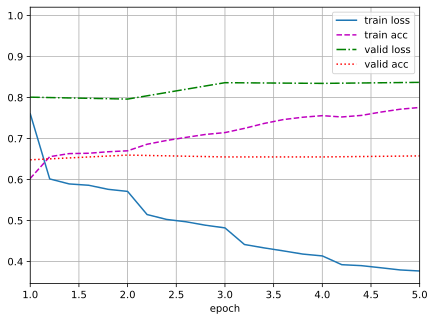

In [ ]:
train_ND(
          teacher_net,
          student_net,
          teacher_train_iter,
          student_train_iter,
          student_dev_iter,
          args.num_epochs,
          args.optimizer,
          args.lr,
          args.weight_decay,
          args.num_warmup_steps,
          devices,
          task_name)

In [ ]:
test(student_net,test_iter,None,device = devices[0])
test_on_checkpoint(student_net, args.pt_path, test_iter, None, device=devices[0])

32it [00:01, 16.77it/s]


test on final epoch -- acc: 64.30, f1-macro: 49.85
test on /content/drive/MyDrive/CS5242/ckpt/NDDualTowerBGE-epoch1-val_acc0.66.pt -- acc: 65.40, f1-macro: 48.52


## LLM

In [23]:
import torch
from transformers import get_cosine_schedule_with_warmup
import copy, os
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "Qwen/Qwen2.5-0.5B"
cache_dir = "/content/drive/MyDrive/CS5242/Qwen2.5-0.5B"

test_data_name = "test_public.json"
train_data_name = "train.json"

args = Args()
args.lr = 3e-4
args.num_epochs=3
args.batch_size=8
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "Relevance with LLM"
download_model(model_name,cache_dir)

Total Parameters: 494,032,768, Trainable: 494,032,768
Qwen2Model(
  (embed_tokens): Embedding(151936, 896)
  (layers): ModuleList(
    (0-23): 24 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=896, out_features=896, bias=True)
        (k_proj): Linear(in_features=896, out_features=128, bias=True)
        (v_proj): Linear(in_features=896, out_features=128, bias=True)
        (o_proj): Linear(in_features=896, out_features=896, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
        (up_proj): Linear(in_features=896, out_features=4864, bias=False)
        (down_proj): Linear(in_features=4864, out_features=896, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((896,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEmbedding()
)


In [24]:
class Qwen2LLMDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = \
        """你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。
           请根据以下规则打分，范围 0 到 2：\n
           0-无关；1-一般相关；2-相关。"""
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请给出相关性评分（仅填写数字）："
                },
                {"role": "assistant", "content": label}
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False
            )
            encoded = self.tokenizer(
                prompt,
                truncation=False,
                padding=False,
                return_tensors=None
            )
            input_ids = encoded['input_ids'] + [self.tokenizer.eos_token_id]
            attenttiom_mask = encoded['attention_mask'] + [1]
            label_ids = input_ids[-4:]
            labels = [-100] * (len(input_ids) - 4) + label_ids

            self.data.append({
                "input_ids": input_ids,
                "attention_mask":attenttiom_mask,
                "labels": labels
            })

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_collate_fn(tokenizer):
    def collate_fn(batch):
        # 把 list-of-dicts 拆成三个 list-of-lists
        input_ids_list     = [torch.tensor(ex["input_ids"],     dtype=torch.long) for ex in batch]
        attention_list     = [torch.tensor(ex["attention_mask"], dtype=torch.long) for ex in batch]
        labels_list        = [torch.tensor(ex["labels"],        dtype=torch.long) for ex in batch]
        from torch.nn.utils.rnn import pad_sequence

        # 手动 pad_sequence
        input_ids_padded      = pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_padded      = pad_sequence(attention_list, batch_first=True, padding_value=0)
        labels_padded         = pad_sequence(labels_list, batch_first=True, padding_value=-100)

        return {
            "input_ids":      input_ids_padded,
            "attention_mask": attention_padded,
            "labels":         labels_padded,
        }
    return collate_fn

class Qwen2LLMTestDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = \
        """你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。
           请根据以下规则打分，范围 0 到 2：\n
           0-无关；1-一般相关；2-相关。"""
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])  # e.g. "0","1","2"
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请给出相关性评分（仅填写数字）："
                },
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=False
            )
            self.data.append({"prompt":prompt,"label":label})

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_test_collate_fn(tokenizer):
    def collate_fn(batch):
        prompts = [sample['prompt'] for sample in batch]
        labels = [item['label'] for item in batch]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(devices[0])
        return {
            "input_ids":      inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels":         labels
        }
    return collate_fn

def train_llm_batch(net, batch, optimizer, device):
    net.train()
    optimizer.zero_grad()
    # Move inputs and labels to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch.get('attention_mask', None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)
    labels = batch['labels'].to(device)

    # Forward pass
    outputs = net(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )
    loss = outputs.loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    return loss.item()


def train_llm(
    net,
    train_loader,
    valid_loader=None,
    num_epochs=3,
    lr=5e-5,
    wd=0.0,
    num_warmup_steps=0,
    device=None,
    monitor="loss",
    task_name="llm_task",
    output_dir="."
):
    """
    Train a language model with a cosine scheduler and optional validation.

    Args:
        net: the model to train
        train_loader: DataLoader for training
        valid_loader: DataLoader for validation (optional)
        num_epochs: number of epochs
        lr: learning rate
        wd: weight decay
        num_warmup_steps: steps for learning rate warmup
        device: torch device (e.g., 'cuda' or 'cpu')
        task_name: prefix for saved checkpoint
        output_dir: directory to save the best model
    """


    # Setup device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
    total_steps = num_epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_steps
    )

    best_metric = float('inf')
    best_state = None
    best_filename = None

    # Training loop
    for epoch in range(1, num_epochs + 1):
        net.train()
        epoch_loss = 0.0
        num_samples = 0

        for batch in tqdm(train_loader):
            loss = train_llm_batch(net, batch, optimizer, device)
            batch_size = batch['input_ids'].size(0)
            epoch_loss += loss * batch_size
            num_samples += batch_size
            scheduler.step()

        train_loss = epoch_loss / num_samples
        print(f"Epoch {epoch}/{num_epochs} - train loss: {train_loss:.4f}")

        # Validation
        if valid_loader is not None:
            net.eval()
            val_loss = 0.0
            val_samples = 0
            with torch.no_grad():
                for batch in valid_loader:
                    # Reuse train_llm_batch for forward w/o optimizer updates
                    batch_loss = train_llm_batch(net, batch, optimizer, device)
                    bs = batch['input_ids'].size(0)
                    val_loss += batch_loss * bs
                    val_samples += bs
            val_loss /= val_samples
            print(f"Epoch {epoch}/{num_epochs} - valid loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_metric:
                best_metric = val_loss
                best_state = copy.deepcopy(net.state_dict())
                best_filename = f"{task_name}-epoch{epoch}-val{val_loss:.4f}.pt"

    # Save the best model if available
    if best_state is not None and best_filename is not None:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, best_filename)
        torch.save(best_state, save_path)
        print(f"Best model saved to {save_path} (valid loss: {best_metric:.4f})")
    else:
        print("Training completed. No validation improvements to save.")
def test_llm(net,test_iter):
  net.eval()
  gt = []
  with torch.no_grad():
    for batch in test_iter:
      outputs = net.generate(**batch)
      generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
      gt += batch['labels']

In [25]:
from collections import Counter
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:45000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:5000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)
labels = [ex["label"] for ex in train_examples]
dist = Counter(labels)
print("Data Information",dist)
train_data = Qwen2LLMDataset(model_name, cache_dir,train_examples)
dev_data = Qwen2LLMDataset(model_name, cache_dir,dev_examples)
test_data = Qwen2LLMTestDataset(model_name, cache_dir,test_examples)

train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_qwen2_test_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Data Information Counter({1: 25126, 0: 9757, 2: 5117})


Preparing ChatML prompts: 100%|██████████| 5000/5000 [00:00<00:00, 20445.74it/s]


In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)
net = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    torch_dtype="auto",
    trust_remote_code=True,
    device_map="cuda:0"
)

train_llm(
          net,
          train_iter,
          None,
          args.num_epochs,
          args.lr,
          args.weight_decay,
          args.num_warmup_steps,
          devices[0],
          monitor="loss",
          task_name=task_name)

100%|██████████| 5000/5000 [18:03<00:00,  4.62it/s]


Epoch 1/3 - train loss: 0.2900


100%|██████████| 5000/5000 [18:01<00:00,  4.62it/s]


Epoch 2/3 - train loss: 0.2189


100%|██████████| 5000/5000 [18:02<00:00,  4.62it/s]

Epoch 3/3 - train loss: 0.2029
Training completed. No validation improvements to save.


In [34]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left",
    cache_dir=cache_dir,
    trust_remote_code=True
)
pred = []
gt = []
for test_batch in test_iter:
  inputs = {"input_ids": test_batch["input_ids"].to(devices[0]),
            "attention_mask": test_batch["attention_mask"].to(devices[0])}
  generated_ids = net.generate(
    **inputs,
    max_new_tokens=30,
    temperature=1,
    top_k= 2,
    top_p =0.9,
    eos_token_id=tokenizer.eos_token_id,  # 防止无限生成
)
  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs["input_ids"], generated_ids)
]
  generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  for text in generated_texts:
    pred.append(text)
  gt += test_batch['labels']

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct gene

In [35]:
pred_ = [int(ele.strip()) for ele in pred]
gt_ = [int(ele.strip()) for ele in gt]
accuracy = np.mean(np.array(pred_) == np.array(gt_))
accuracy

np.float64(0.5488)

In [33]:
correct = sum(p == l for p, l in zip(predictions, labels))
accuracy = correct / len(labels)
accuracy

NameError: name 'predictions' is not defined

In [18]:
for batch in train_iter:
  a = tokenizer.decode(batch["input_ids"][1])
  print(a)
  print(batch)
  break

NameError: name 'tokenizer' is not defined

In [ ]:
for batch in train_iter:
  generated_ids = batch["input_ids"]
  generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  for text in generated_texts:
    print(text)
    print( "#############")
  break

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tensor([[151644,   8948,    198,  ...,   9754, 101124, 100126],
        [151644,   8948,    198,  ...,    198,  75491,    198],
        [151644,   8948,    198,  ...,  71703,     25,   4891],
        [151644,   8948,    198,  ...,     25,  94305,    245]],
       device='cuda:0')
system
你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。请根据以下规则打分，评分范围为 0 到 2：
          0：无关（文档内容与查询主题完全不相关）
          1：一般相关（部分关键词相符，可能主题不完全一致或内容较模糊）
          2：相关（文档内容明确与查询紧密相关）

          下面是一些示例：

          用户查询：淘宝里面图片轮播怎么上图片啊  
          文档片段：淘宝店铺里的轮播图片宝贝怎么弄上去啊百度知道  
          评分：2

          用户查询：淘宝首页装修怎么添加视频模块  
          文档片段：教你如何在淘宝详情页插入商品视频教程  
          评分：1

          用户查询：如何关闭淘宝自动续费服务  
          文档片段：淘宝直播间的开通方法及注意事项  
          评分：0

          用户查询：淘宝客服回复快捷短语怎么设置  
          文档片段：淘宝千牛工作台设置快捷短语教程  
          评分：2

          用户查询：怎么上传淘宝主图视频  
          文档片段：主图视频只能在商品发布页面添加，详情页无法更改  
          评分：1
        
user
查询内容：离婚申请之日起任何一方不同意离婚可以向
文档片段：依据《中华人民共和国民法典》规定自婚姻登记机关收到离婚登记申请之日起任何一方不愿意离婚的可以向婚姻登记机关离婚登记申请3g免费网

assista

In [34]:
from transformers import TextStreamer

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt},
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
model_inputs = tokenizer([text], return_tensors="pt").to(net.device)

generated_ids = net.generate(
    **model_inputs,
    max_new_tokens=512,
    do_sample=True,
    top_p=0.9,
    temperature=0.8,
    repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id,

)
# generated_ids = [
#     output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
# ]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


"system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.\nuser\nGive me a short introduction to large language model.\nassistant\nLarge Language Model (LLM) is an artificial intelligence system designed for processing and generating human-like text in natural languages. It uses powerful algorithms like transformer models from the field of machine learning.\n\n Comey \xa0–\n\n Comey was born on February 21, 1960 at the Bronx Hospital with his mother, Marie-Eve Reardon-Whitney, Jr., and father James Comey, Sr. He grew up with several brothers and sisters including Stephen Lee; Robert Michael; Christopher Philip; Kenneth Thomas; Jeffrey John; Donald David; Edward Patrick; Timothy William; Nicholas Joseph; Jason Aaron; and Andrew Paul.\n Comey graduated from Stuyvesant High School in 1983 and earned both degrees summa cum laude. He then attended the University of California Berkeley where he received a Bachelor’s degree in Philosophy under Dean Brian Greene in May 1987

In [ ]:
# 自定义采样参数
outputs = net.generate(
    **inputs,
    max_new_tokens=128,
    do_sample=True,       # 启用采样
    temperature=0.5,      # 控制输出的多样性（越小越保守）
    top_k=5,             # 只从概率前50的token中采样
    top_p=0.9,           # nucleus sampling
    num_return_sequences=1, # 每个prompt生成1个序列（可改为多样性生成）
    eos_token_id=tokenizer.eos_token_id,  # 防止无限生成
)

In [13]:
generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
generated_texts

['请解释一下牛顿第一定律。 牛顿第一定律，也称为惯性定律，是经典力学中的基本原理之一。它描述了物体保持其静止或匀速直线运动状态的性质。具体来说，牛顿第一定律可以表述为：如果一个物体不受外力作用，那么它将保持静止状态或匀速直线运动状态。\n\n这个定律的核心思想是：物体的运动状态不会因为外部力量的介入而改变。换句话说，即使物体没有受到任何外力的作用，它仍然会继续沿着原有的路径运动，直到遇到新的外力或达到一个新的平衡状态。\n\n牛顿第一定律对于理解物体的',
 '黑洞是如何形成的？在宇宙中，黑洞是如何形成的？\n\n黑洞的形成是一个复杂的过程，涉及到多个物理定律和理论。以下是黑洞形成的几个关键步骤：\n\n1. **恒星演化**：当一颗大质量恒星（通常超过太阳质量的20倍）耗尽其核心燃料时，它会发生一系列的演化过程。首先，恒星的核心会坍缩，形成一个称为白矮星（比太阳小得多的恒星）的结构。随后，这个白矮星可能会继续坍缩，形成中子星或黑洞。\n\n2. **中子星**：在中子星形成的过程中，恒',
 '什么是量子纠缠？量子纠缠是量子力学中的一个概念，指的是两个或多个粒子之间的相互作用，使得它们的状态无法被单独描述，而只能通过描述它们的组合来描述。这种相互作用是如此的紧密，以至于当其中一个粒子的状态发生变化时，另一个粒子的状态也会随之改变，这种现象被称为量子纠缠。\n量子纠缠的产生是由于量子力学中的叠加态。当两个粒子处于不同的状态时，它们的状态是叠加的，这意味着它们可以同时存在于不同的位置。当其中一个粒子的状态发生变化时，另一个粒子的状态也会随之改变，这种现象被称为量子纠缠。\n量子纠缠的另一个重要特点是它的非线']

In [56]:
system_prompt = "你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。"
query= "ni"
document = "3"
label = "1"
messages = [
    {"role": "system", "content": system_prompt},
    {
        "role": "user",
        "content":
            f"查询内容：{query}\n文档片段：{document}\n请根据相关性打分，评分范围为 0 到 2：\n"
            f"0：无关\n1：一般相关\n2：相关\n你的回答（仅填写数字）："
    },
    {"role": "assistant", "content": label}
]
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)
prompt = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=False,
                tokenize=False
            )
encoded = tokenizer(
  prompt,
  truncation=True,
  padding=False,
  return_tensors=None
)
input_ids = encoded['input_ids']
# 只有最后 3 个 token 作为 label，其它位置都为 -100
label_ids = input_ids[-3:]
labels = [-100] * (len(input_ids) - 3) + label_ids
prompt

'<|im_start|>system\n你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。<|im_end|>\n<|im_start|>user\n查询内容：ni\n文档片段：3\n请根据相关性打分，评分范围为 0 到 2：\n0：无关\n1：一般相关\n2：相关\n你的回答（仅填写数字）：<|im_end|>\n<|im_start|>assistant\n1<|im_end|>\n'

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [67]:
outputs

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 5.8792,  9.3359,  8.1893,  ..., -4.5367, -4.5373, -4.5367],
         [ 4.3462, 11.6389,  6.9472,  ..., -3.9331, -3.9340, -3.9332],
         [ 4.0576, 12.3034,  5.9505,  ..., -4.1351, -4.1350, -4.1352],
         ...,
         [ 5.2344, 11.0406,  7.8873,  ..., -6.7608, -6.7591, -6.7606],
         [ 7.9003, 13.1896, 10.7696,  ..., -5.2308, -5.2302, -5.2307],
         [ 9.7818, 11.1747,  9.8012,  ..., -7.2374, -7.2365, -7.2373]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x7fc995ce4c50>, hidden_states=None, attentions=None)

In [49]:
inputs

{'input_ids': tensor([[ 14880, 104136, 100158, 100664, 100255,  99363, 117250,   1773]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# 加载模型和 tokenizer
model_name = "THUDM/chatglm3-6b"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).cuda()
model.eval()

# 设置输入问题
query = "请介绍一下人工智能的发展历史"

# 推理（不保留历史）
response, _ = model.chat(tokenizer, query, history=[])

# 打印回答
print("🧠 ChatGLM3 回复：\n", response)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [26]:
!pip show transformers
from transformers import Cache

Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers
